# SIR model for COVID-19 reproducing the paper from Ma, 2022

In [1]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
%matplotlib widget
%config InlineBackend.figure_format='retina'

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda I\left(t \right) \tag{3} \end{align*}

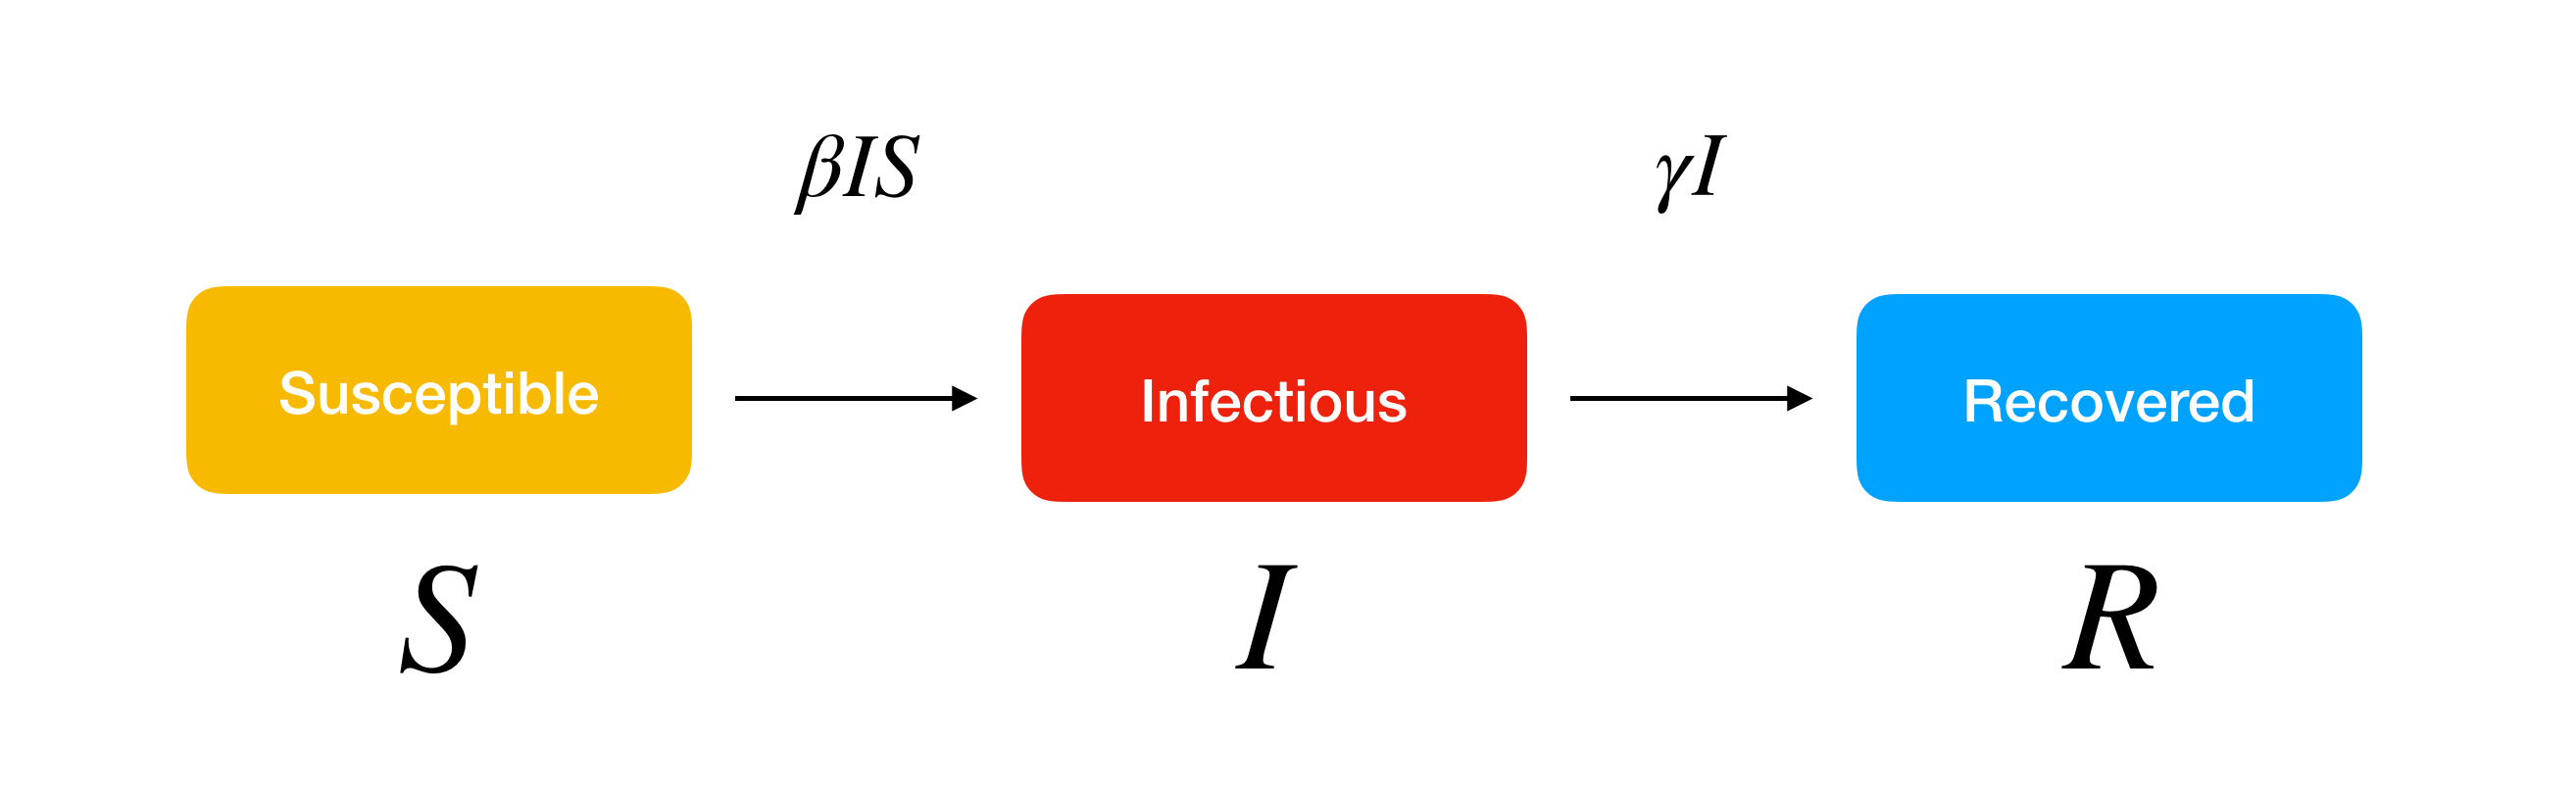

### Extended SEIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} &= \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} &= \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} &= \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} &= \alpha S\left(t \right) \tag{10} \end{align*}

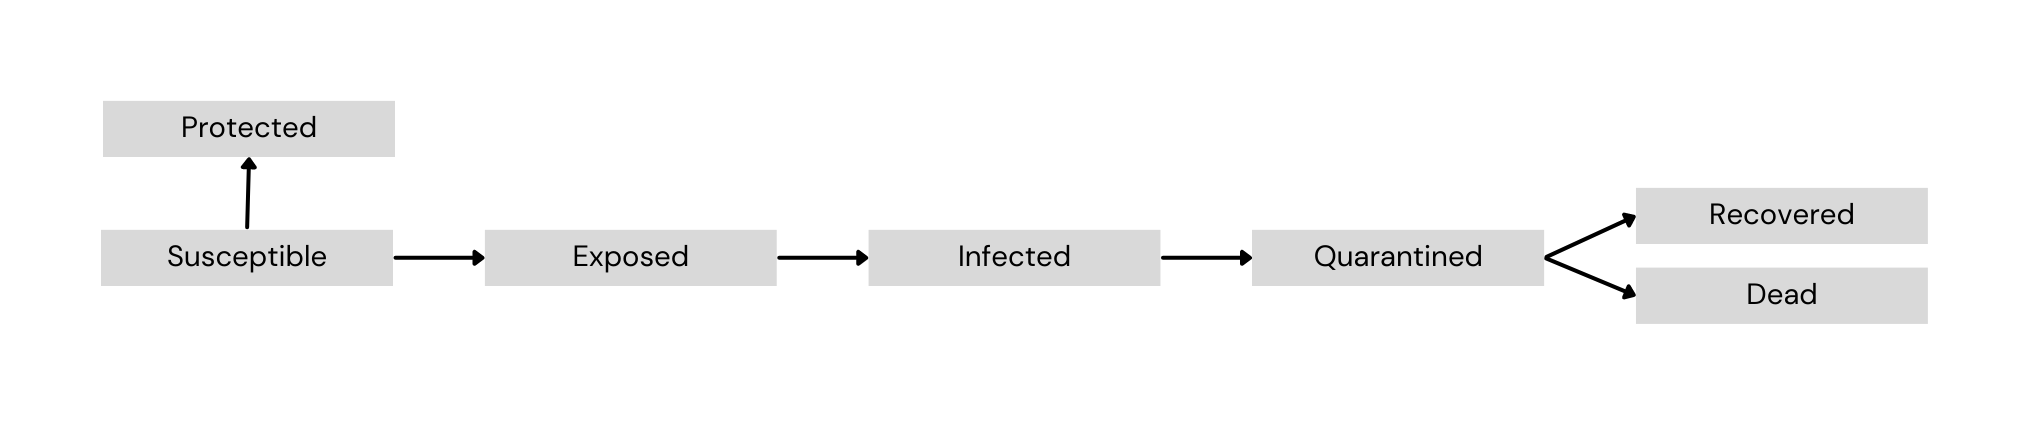

### States of the SEIR model

- $S$: susceptible people
- $E$: exposed people
- $I$: infected people not quarantined
- $Q$: infected people quarantined
- $R$: recovered people
- $D$: dead people
- $P$: protected people

### Parameters of the SEIR model
- $N$: total number of people
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^{-1}$: average incubation time
- $\delta^{-1}$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate

The `local_SEIR.py` file contains two functions, one is `solveSEIR` which is intended for using in a notebook and experiment with different inputs and outputs manually, the other is `solveSEIR_UQpy` which is intended for `UQpy` as in only returns the infected number as output.

In [3]:
from local_SEIR import solveSEIR

Set initial parameters with values from the paper.

In [4]:
alpha = 0.0185  # protection rate
beta = 0.7      # infectious rate
gamma_inv = 5   # average incubation time
delta_inv = 7   # average quarantine time
lam = 0.1       # cure rate
kappa = 0.001   # mortality rate

Call the `solveSEIR` function to produce the solution.

In [5]:
sol = solveSEIR(
    input_parameters=[alpha, beta, gamma_inv, delta_inv, lam, kappa])

Plot the results across time, and specify starting and ending day as in the paper.

In [6]:
t = np.linspace(0, 180, 10000)

start_day = 5
end_day = 180
timespan = (t >= start_day) & (t <= end_day)

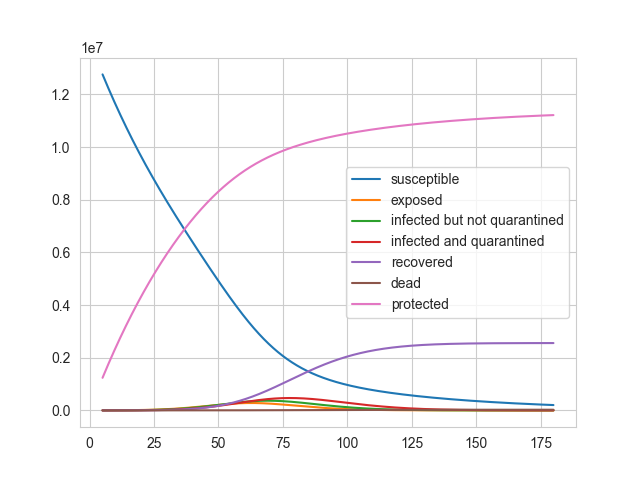

In [7]:
#!pip install --upgrade ipympl
fig, ax = plt.subplots()
ax.plot(t[timespan], sol[0, timespan], label="susceptible")
ax.plot(t[timespan], sol[1, timespan], label="exposed")
ax.plot(t[timespan], sol[2, timespan], label="infected but not quarantined")
ax.plot(t[timespan], sol[3, timespan], label="infected and quarantined")
ax.plot(t[timespan], sol[4, timespan], label="recovered")
ax.plot(t[timespan], sol[5, timespan], label="dead")
ax.plot(t[timespan], sol[6, timespan], label="protected")
ax.legend()
plt.show()

### Basic reproduction number

The basic reproduction number is defined as

\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (I(t)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (I(t)/t)}}{\lambda }} \right) \tag{11} \end{equation*}

where $I(t)$ is the number of infected populations by time $t$.

We define a function to compute it.

In [8]:
def calculate_R0(Y, t, gamma, lam):
    return (1 + np.log(Y/t)/gamma) * (1 + np.log(Y/t)/lam)

### Sensitivity Analysis

Import relevant modules and classes from `UQpy`.

In [9]:
from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Uniform
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *

Create `PythonModel` object.

In [10]:
model = PythonModel(
    model_script="local_SEIR.py", # this file must be in the same folder
    model_object_name="solveSEIR_UQpy", # this is the name of the main function called in local_SEIR.py
    var_names=["alpha", # same order used when unpacking the parameters in solveSEIR
               "beta",
               "gamma_inv",
               "delta_inv",
               "lam",
               "kappa"],
    delete_files=True
)

runmodel_obj = RunModel(model=model)

We set a uniform distribution as in the paper using `UQpy.distributions.Uniform`.

The `Uniform` distribution is based on `scipy` and receives `loc` and `scale`, so if
$$
U\sim U([a,b]) \qquad f_U(x;a,b) = \frac{1}{b-a}
$$
then
$$
a = loc \qquad b = loc + scale
$$
therefore
$$
loc = a \qquad scale = b - a
$$

In [11]:
A     = Uniform(0.085, (0.183 - 0.085 ))
B     = Uniform(0.7, (0.9 - 0.7))
G_inv = Uniform(5, (7 - 5 ))
D_inv = Uniform(7, (14 - 7))
L     = Uniform(0.1, (0.5 - 0.1 ))
K     = Uniform(0.001, (0.05 - 0.001 ))

dist_object = JointIndependent([A, B, G_inv, D_inv, L, K])

Perform the sensitivity analysis and measure the time taken by the cell to execute it.

In [12]:
%%time
SA = SobolSensitivity(runmodel_obj, dist_object)
SA.run(n_samples=2000, estimate_second_order=True)

CPU times: user 1min 41s, sys: 12.3 s, total: 1min 54s
Wall time: 1min 59s


Investigate the shape of the resulting quantities.

In [13]:
np.shape(SA.first_order_indices)

(6, 10000)

In [14]:
np.shape(SA.second_order_indices)

(15, 10000)

Plot the first order indexes in 3D.

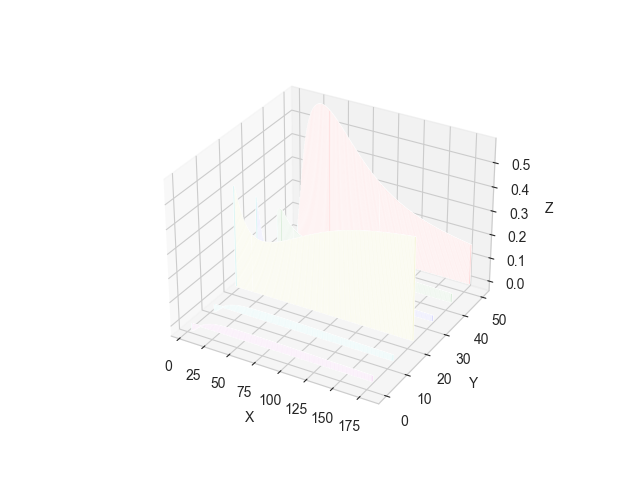

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

c = ['r', 'g', 'b', 'y', 'c', 'm']
z = [50, 40, 30, 20, 10, 0]

for i in range(np.shape(SA.first_order_indices.T[1:])[1]):
    xs = t[timespan]
    ys = SA.first_order_indices[i, timespan]
    
    # subsample every 100
    xs = xs[::30]
    ys = ys[::30]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c[i]] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z[i], zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Plotting first order Sobol indices in time

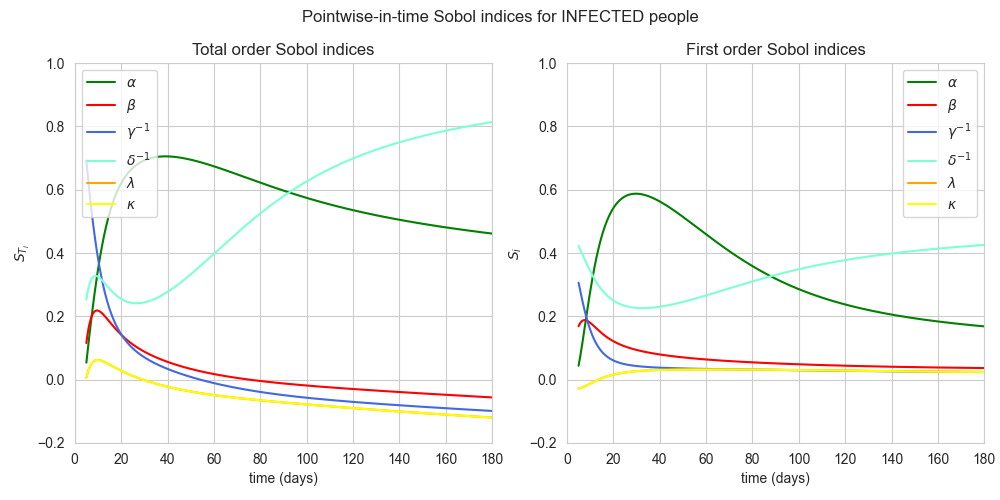

In [21]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Total order
ax[0].plot(t[timespan], SA.total_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[0].plot(t[timespan], SA.total_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[0].plot(t[timespan], SA.total_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[0].plot(t[timespan], SA.total_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[0].plot(t[timespan], SA.total_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[0].plot(t[timespan], SA.total_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[0].set_title("Total order Sobol indices")
ax[0].set_xlabel("time (days)")
ax[0].set_ylabel(r"$S_{T_i}$")
ax[0].set_xbound(0, t[-1])
ax[0].set_ybound(-0.2, 1)
ax[0].legend()

# First order
ax[1].plot(t[timespan], SA.first_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[1].plot(t[timespan], SA.first_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[1].plot(t[timespan], SA.first_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[1].plot(t[timespan], SA.first_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[1].plot(t[timespan], SA.first_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[1].plot(t[timespan], SA.first_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[1].set_title("First order Sobol indices")
ax[1].set_xlabel("time (days)")
ax[1].set_ylabel(r"$S_i$")
ax[1].set_xbound(0, t[-1])
ax[1].set_ybound(-0.2, 1)
ax[1].legend()

fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people")
fig.tight_layout(pad=1.0)

plt.show()

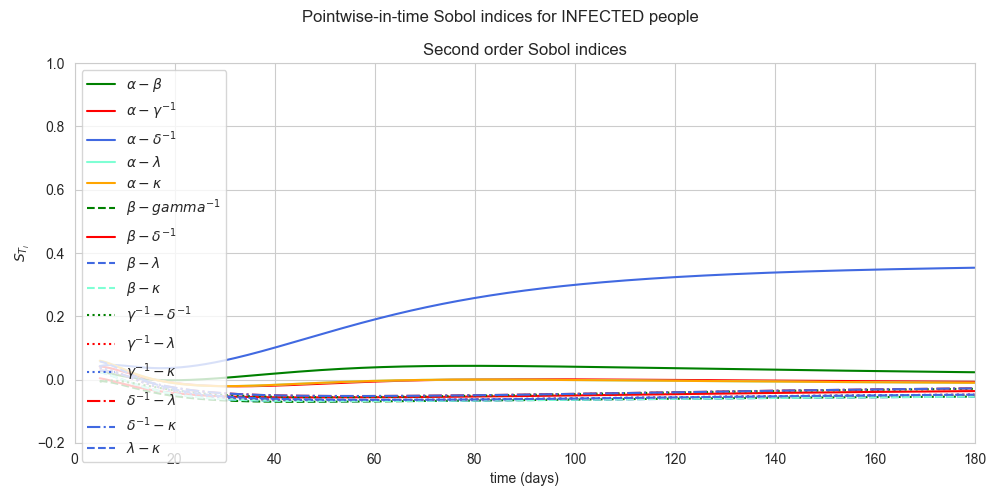

In [40]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig, ax = plt.subplots(figsize=(10,5))

# Alpha
ax.plot(t[timespan], SA.second_order_indices[0, timespan], "g",label=r"$\alpha-\beta$")
ax.plot(t[timespan], SA.second_order_indices[1, timespan], "r" ,label=r"$\alpha-\gamma^{-1}$")
ax.plot(t[timespan], SA.second_order_indices[2, timespan], label=r"$\alpha-\delta^{-1}$", color="royalblue")
ax.plot(t[timespan], SA.second_order_indices[3, timespan], label=r"$\alpha-\lambda$", color="aquamarine")
ax.plot(t[timespan], SA.second_order_indices[4, timespan], label=r"$\alpha-\kappa$", color="orange")

ax.plot(t[timespan], SA.second_order_indices[5, timespan], "g",label=r"$\beta-\gamma^{-1}$", linestyle='dashed')
ax.plot(t[timespan], SA.second_order_indices[6, timespan], "r" ,label=r"$\beta-\delta^{-1}$")
ax.plot(t[timespan], SA.second_order_indices[7, timespan], label=r"$\beta-\lambda$", color="royalblue", linestyle='dashed')
ax.plot(t[timespan], SA.second_order_indices[8, timespan], label=r"$\beta-\kappa$", color="aquamarine", linestyle='dashed')

ax.plot(t[timespan], SA.second_order_indices[9, timespan], "g",label=r"$\gamma^{-1}-\delta^{-1}$", linestyle='dotted')
ax.plot(t[timespan], SA.second_order_indices[10, timespan], "r" ,label=r"$\gamma^{-1}-\lambda$", linestyle='dotted')
ax.plot(t[timespan], SA.second_order_indices[11, timespan], label=r"$\gamma^{-1}-\kappa$", color="royalblue", linestyle='dotted')

ax.plot(t[timespan], SA.second_order_indices[12, timespan], "r" ,label=r"$\delta^{-1}-\lambda$", linestyle='dashdot')
ax.plot(t[timespan], SA.second_order_indices[13, timespan], label=r"$\delta^{-1}-\kappa$", color="royalblue", linestyle='dashdot')

ax.plot(t[timespan], SA.second_order_indices[14, timespan], label=r"$\lambda-\kappa$", color="royalblue", linestyle='dashed')
#, linestyle='dashed'

#ax[0].plot(t[timespan], SA.second_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax.set_title("Second order Sobol indices")
ax.set_xlabel("time (days)")
ax.set_ylabel(r"$S_{T_i}$")
ax.set_xbound(0, t[-1])
ax.set_ybound(-0.2, 1)
ax.legend()

fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people")
fig.tight_layout(pad=1.0)

plt.show()

#### General comments

- The time dynamics of the first-order Sobol index for each parameter fully reproduces the results from the paper
- The parameter alpha, modelling the protection rate, is the most highli influential for the number of infected cases
- Also the average quarantine time seems to have a very important role 


#### Comments on the first order Sobol

#### Comments on the total order Sobol

#### Comments on the second order Sobol



### 

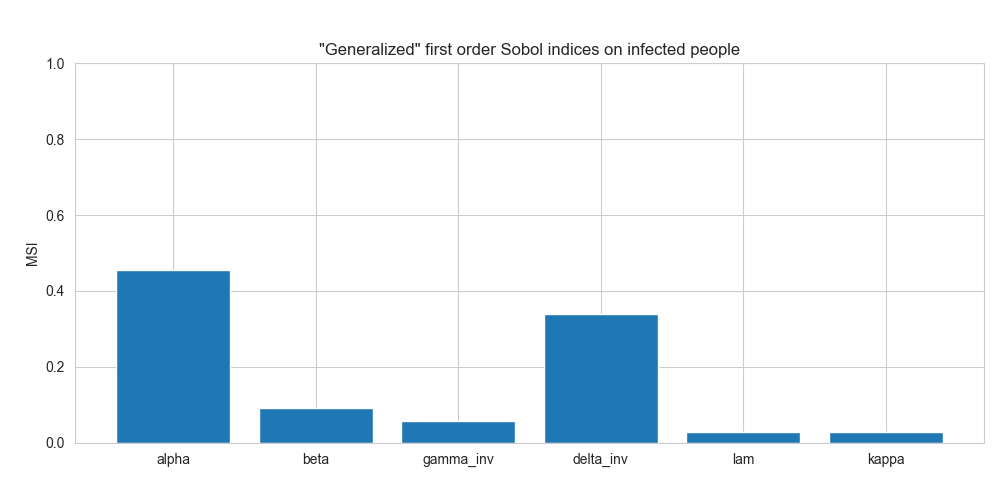

In [19]:
from scipy.integrate import cumulative_trapezoid

sobol_first = SA.first_order_indices[:, timespan]
# Set to zero negative elements
sobol_first[sobol_first < 0] = 0

x = t[timespan]

num_inputs = np.shape(SA.first_order_indices)[0]

# Initialize output vector
first_s_int = np.zeros(num_inputs)

# Compute strange integral
for i in range(num_inputs):
    y = sobol_first[i, :]
    result = cumulative_trapezoid(y, x)
    first_s_int[i] = sum(result)

# Normalize with the sum of all
first_s_int = first_s_int / np.sum(first_s_int)

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

plt.clf()
plt.bar(var_names, first_s_int)

plt.ylim(0,1)
plt.ylabel('MSI')
plt.title('"Generalized" first order Sobol indices on infected people')
plt.show()

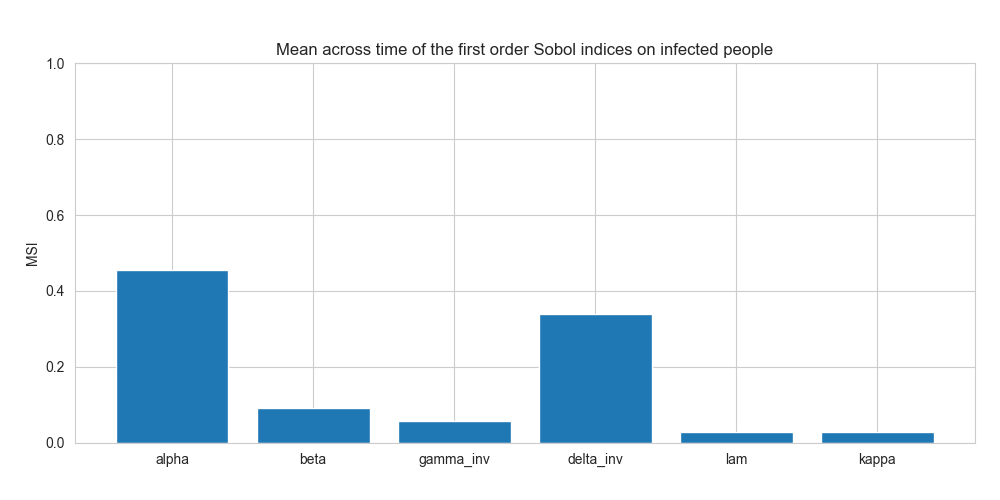

In [39]:
#Approach 2: mean over time
first_order_sobol_mean=np.array(np.zeros(6))
total_sobol_mean=np.array(np.zeros(6))

#Starting from day 5 as they did
for i in range(6):
    first_order_sobol_mean[i]=np.mean(SA.first_order_indices[i, timespan])
    total_sobol_mean[i]=np.mean(SA.total_order_indices[i, timespan])
    

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

plt.clf()
plt.bar(var_names, first_s_int)

plt.ylim(0,1)
plt.ylabel('MSI')
plt.title('Mean across time of the first order Sobol indices on infected people')
plt.show()

#### Factor prioritization from first order sobol indices

Independently of the method chosen, the ranking of the factors according to the first-order Sobol index is the following

1. $\alpha$
2. $\delta^{-1}$
3. $\beta$
4. $\gamma^{-1}$
5. $\lambda$ and $\kappa$